CCDF data written to Excel sheet: 'CCDF (PORE Oh to OCT O01)'
Fit parameters written to YAML file:
/media/mmh/ExtraSpace/Final_Pore_Analysis_Organized_TNS/pore_D3_L6_W2_S5.0_E0.0_A0.0_V0.0_no_reservoir_N1/OCT/358K/5_nvt_prod_system_short_run/Analysis/OCT_O01_C0O/HBonds/hbonds_analysis_ccdf_fit.yaml
{'A': {'value': 1.5102744953437524, 'variance': 2.3027524671876483e-05, 'std_error': 0.00479870031069627}, 'p': {'value': 0.1744421119319144, 'variance': 2.407455709397964e-07, 'std_error': 0.0004906583036490837}, 'x_c': {'value': 13177.464087331455, 'variance': 254.26030726744412, 'std_error': 15.945541924545685}, 'k': {'value': 2.069362367644246, 'variance': 7.338837194420036e-05, 'std_error': 0.008566701345570554}}


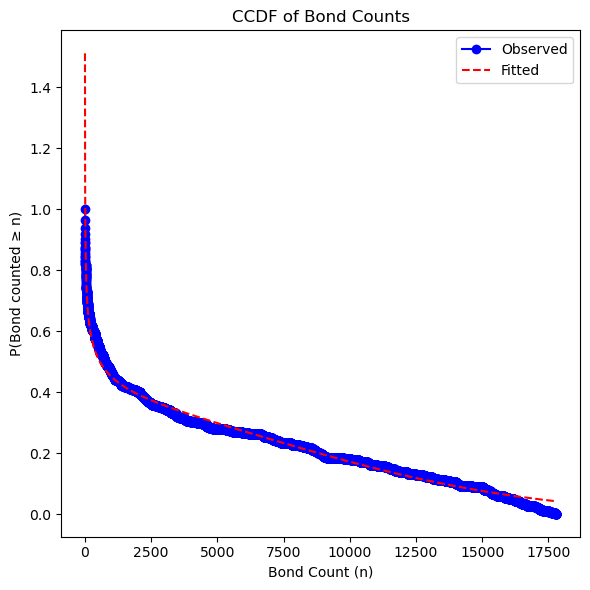

In [ ]:
# =========================================
# ===== Hydrogen bond CCDF calculator =====
# =========================================

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yaml

from scipy.optimize import curve_fit

# ===== Selections (make sure file_path points to hbonds_analysis.xlsx)
file_path = "/media/mmh/ExtraSpace/Final_Pore_Analysis_Organized_TNS/pore_D3_L6_W2_S5.0_E0.0_A0.0_V0.0_no_reservoir_N1/OCT/358K/5_nvt_prod_system_short_run/Analysis/OCT_O01_C0O/HBonds/hbonds_analysis.xlsx"

donor_resname = "PORE"
donor_atom = "Oh"
acceptor_resname = "OCT"
acceptor_atom = "O01"

# donor_resname = "OCT"
# donor_atom = "O01"
# acceptor_resname = "VAN"
# acceptor_atom = "OVH"

# donor_resname = "OCT"
# donor_atom = "O01"
# acceptor_resname = "OCT"
# acceptor_atom = "O01"

# donor_resname = "OCT"
# donor_atom = "O01"
# acceptor_resname = "LNK"
# acceptor_atom = "NL"

# donor_resname = "LNK"
# donor_atom = "NL"
# acceptor_resname = "OCT"
# acceptor_atom = "O01"

# donor_resname = "OCT"
# donor_atom = "O01"
# acceptor_resname = "PORE"
# acceptor_atom = "Oh"

# donor_resname = "VAN"
# donor_atom = "OVH"
# acceptor_resname = "OCT"
# acceptor_atom = "O01"

# donor_resname = "OCT"
# donor_atom = "O01"
# acceptor_resname = "PORE"
# acceptor_atom = "Os"

# ===== Double exponential decay model
def double_exponential_decay(x, A, tau1, B, tau2, C):
    return A * np.exp(-x / tau1) - B * np.exp(-x / tau2) + C

def powerlaw_cutoff(x, A, p, x_c, k):
    """
🔹 AA — Amplitude / Scale factor

    Controls the overall height of the curve.

    Think of it as the initial probability level or normalization.

    If you're modeling a probability distribution (e.g., survival, failure, etc.), you might later normalize this.

🔹 pp — Power-law exponent

    Governs the slope of the decay on a log-log plot before the cutoff.

    A larger pp means a steeper drop in the early (pre-cutoff) region.

    For example:

        p=1p=1: mild decay

        p=2p=2: steeper decay

🔹 xcxc​ — Cutoff point / Inflection location

    Sets the position along the x-axis where the curve bends sharply down.

    Before x≈xcx≈xc​, the power-law dominates.

    After x>xcx>xc​, the cutoff term takes over, and the decay accelerates.

You can think of xcxc​ as the "half-life of the power-law regime".
🔹 kk — Cutoff sharpness

    Controls how sharp or gradual the transition from power-law to fast decay is.

    Interpreted as:

kk value	Meaning	Behavior
k=1k=1	Exponential cutoff	Standard smooth decay
k<1k<1	Soft cutoff	Gradual bend, long tail
k>1k>1	Sharp cutoff	Sudden fall, quick drop-off

A good fit might have k≈2k≈2 for a steep drop (super-exponential).
    """
    return A / (x**p) * np.exp(-(x / x_c)**k)

# ===== Initial parameter guess
p_guess = [1.47, 0.155, 15000, 4]
param_names = ['A', 'p', 'x_c', 'k']

# ===========================
# ===== Automated tasks =====
# ===========================
df_data = pd.read_excel(file_path, sheet_name="Unique pairs (index dep.)")
mask = (
    (df_data["Donor_resname"] == donor_resname) &
    (df_data["Donor_atom"] == donor_atom) &
    (df_data["Acceptor_resname"] == acceptor_resname) &
    (df_data["Acceptor_atom"] == acceptor_atom)
)
df_masked = df_data[mask]
counts = df_masked["count"].values
max_count = counts.max()

bins = np.arange(1, max_count + 2)
hist, bin_edges = np.histogram(counts, bins=bins)
ccdf = np.cumsum(hist[::-1])[::-1] / np.sum(hist)
x_vals = bin_edges[:-1]

bounds = ([0, 0, -np.inf, 1], [np.inf, np.inf, np.inf, 1000])

# popt, pcov = curve_fit(double_exponential_decay, x_vals, ccdf, p0=p_guess, bounds=(0, np.inf))
# param_variances = np.diag(pcov)
# param_std_errors = np.sqrt(param_variances)
# ccdf_fit_at_x = double_exponential_decay(x_vals, *popt)

popt, pcov = curve_fit(powerlaw_cutoff, x_vals, ccdf, p0=p_guess, bounds=(0, np.inf))
param_variances = np.diag(pcov)
param_std_errors = np.sqrt(param_variances)
ccdf_fit_at_x = powerlaw_cutoff(x_vals, *popt)

data_table = pd.DataFrame({
    "Bond Count (n)": x_vals,
    "Observed CCDF": ccdf,
    "Fitted CCDF": ccdf_fit_at_x
})

sheet_name = f"CCDF ({donor_resname} {donor_atom} to {acceptor_resname} {acceptor_atom})"
with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    data_table.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"CCDF data written to Excel sheet: '{sheet_name}'")

fit_data = {}
for name, val, var, err in zip(param_names, popt, param_variances, param_std_errors):
    fit_data[name] = {
        "value": float(val),
        "variance": float(var),
        "std_error": float(err)
    }

pair_key = f"{donor_resname}/{donor_atom} : {acceptor_resname}/{acceptor_atom}"

fit_data_entry = {
    name: {
        "value": float(val),
        "variance": float(var),
        "std_error": float(err)
    }
    for name, val, var, err in zip(param_names, popt, param_variances, param_std_errors)
}

yaml_path = os.path.splitext(file_path)[0] + "_ccdf_fit.yaml"

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        all_fit_data = yaml.safe_load(f) or {}
else:
    all_fit_data = {}

all_fit_data[pair_key] = fit_data_entry

with open(yaml_path, 'w') as f:
    yaml.safe_dump(all_fit_data, f, sort_keys=False)

print(f"Fit parameters written to YAML file:\n{yaml_path}")

print(fit_data_entry)

plt.figure(figsize=(6, 6))
plt.plot((x_vals), (ccdf), 'o-', label='Observed', color='blue')
plt.plot(x_vals, ccdf_fit_at_x, '--', label='Fitted', color='red')
plt.xlabel("Bond Count (n)")
plt.ylabel("P(Bond counted ≥ n)")
plt.title("CCDF of Bond Counts")
plt.legend()
plt.tight_layout()
plt.show()

Analyze all of the short runs
Whittle at CCDF fits
Double check all of the Hydrogen bond counts (and provide which ones were mixed up)
Analyze hydroxy vectors

Figure out how to get 10 heatmaps on the same page